# Player Transfermrket Value Estimator 

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 23.1 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", None, "display.max_rows", None)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/UT/Plan\ II\ \(General\)/Thesis/Model

/content/gdrive/MyDrive/UT/Plan II (General)/Thesis/Model


In [ ]:
onethirty_features=pd.read_csv('onethirty_features.csv')

## Training and Tuning

In [ ]:
# Imports
!pip install catboost

     |████████████████████████████████| 76.4 MB 24 kB/s 


In [ ]:
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Going to train CatBoost on the largest feature set, since it produced the best RMSLE.

### Baseline CatBoost

Going to start by seeing what the baseline (not tuned) model does against the test set. Then going to tune some of the hyperparams around what is listed.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(onethirty_features.drop(columns=['Log Value']), onethirty_features['Log Value'], random_state=42, test_size=0.1)

In [ ]:
untuned = CatBoostRegressor(loss_function='MAPE')

untuned.fit(X_train, y_train)

In [ ]:
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, untuned.predict(X_train))*100} %')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, untuned.predict(X_test))*100} %')

Train MAPE: 1.690462453337391 %
Test MAPE: 3.7182378366747497 %


In [ ]:
untuned.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'MAPE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Exact',
 'learning_rate': 0.029999999329447743,
 'loss_function': 'MAPE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929,

Clearly there is some overfitting going on. Going to try tuning to see what can be done.

### Tuning 1

In [ ]:
cv = RepeatedKFold(n_splits = 3, random_state = 42, n_repeats=2)
model = CatBoostRegressor(logging_level='Silent', loss_function='MAPE')

grid = {'depth' : [5,6,7],
        'learning_rate' : [0.01, 0.025, 0.035],
        'iterations'    : [1000, 1250, 1500],
        'l2_leaf_reg' : [2,3]
       }


search = GridSearchCV(model, grid, scoring='neg_mean_absolute_percentage_error', cv=cv, verbose=3)

In [ ]:
tuning_one = search.fit(X_train, y_train)

In [ ]:
print(tuning_one.best_params_)

{'depth': 5, 'iterations': 1500, 'l2_leaf_reg': 2, 'learning_rate': 0.035}


In [ ]:
# Used to avoid running tuning

tuning_one = CatBoostRegressor(depth=5, iterations=1500, l2_leaf_reg = 2, learning_rate = 0.035)
tuning_one.fit(X_train, y_train)

In [ ]:
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, tuning_one.predict(X_train))*100} %')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, tuning_one.predict(X_test))*100} %')

Train MAPE: 1.0748553804005367 %
Test MAPE: 3.67079441889439 %


### Tuning 2 (Overfit Prevention)

In [ ]:
cv = RepeatedKFold(n_splits = 3, random_state = 42, n_repeats=2)
model = CatBoostRegressor(logging_level='Silent', loss_function='MAPE')

grid = {'depth' : [5,6],
        'learning_rate' : [0.025, 0.03, 0.035],
        'iterations'    : [1250, 1500],
        'l2_leaf_reg' : [2,3]
       }

eval_pool = Pool(X_test, y_test)

fit_params = {'eval_set' : eval_pool,
              'early_stopping_rounds' : 10
             }


search = GridSearchCV(model, grid, scoring='neg_mean_absolute_percentage_error', cv=cv, verbose=3)

In [ ]:
tuning_two = search.fit(X_train, y_train, **fit_params)

In [ ]:
print(tuning_two.best_params_)

{'depth': 5, 'iterations': 1250, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


In [ ]:
# Used to avoid running tuning

tuning_two = CatBoostRegressor(depth=5, iterations=1250, l2_leaf_reg = 3, learning_rate = 0.03)
tuning_two.fit(X_train, y_train)

In [ ]:
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, tuning_two.predict(X_train))*100} %')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, tuning_two.predict(X_test))*100} %')

Train MAPE: 1.5791731473297814 %
Test MAPE: 3.6607749095766753 %


### Tuning 3 (More Specific of 1)

In [ ]:
cv = RepeatedKFold(n_splits = 3, random_state = 42, n_repeats=2)
model = CatBoostRegressor(logging_level='Silent', loss_function='MAPE')

grid = {'depth' : [5],
        'learning_rate' : np.arange(0.025, 0.035, 0.001),
        'iterations'    : [1250, 1350, 1500],
       }

eval_pool = Pool(X_test, y_test)

fit_params = {'eval_set' : eval_pool,
              'early_stopping_rounds' : 10
             }


search = GridSearchCV(model, grid, scoring='neg_mean_absolute_percentage_error', cv=cv, verbose=3)

In [ ]:
tuning_three = search.fit(X_train, y_train, **fit_params)

NameError: ignored

In [ ]:
print(tuning_three.best_params_)

{'depth': 5, 'iterations': 1250, 'learning_rate': 0.03200000000000001}


In [ ]:
# Used to avoid running tuning

tuning_three = CatBoostRegressor(depth=5, iterations=1250,  learning_rate = 0.032)
tuning_three.fit(X_train, y_train)

In [ ]:
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, tuning_three.predict(X_train))*100} %')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, tuning_three.predict(X_test))*100} %')

Train MAPE: 1.472366393690954 %
Test MAPE: 3.5880382076856203 %


### Tuning 4 (Combination of Tuning 2 and Tuning 3)

In [ ]:
preds_x = tuning_two.predict(X_test)
preds_y = tuning_three.predict(X_test)

best_weight_x_arr = np.arange(0.0, 1, 0.01)
best_weight_y_arr = np.arange(1, 0.0, -0.01)
best_mape_arr = []

best_weight_x = 0
best_mape_four = 100

for j in np.arange(0.0, 1, 0.01):
  weight_x = j
  weight_y = 1-weight_x

  final_preds = []

  for i in range(len(X_test)):
    pred = (weight_x*preds_x[i]) + (weight_y*preds_y[i])
    final_preds.append(pred)

  mape = mean_absolute_percentage_error(y_test, final_preds)*100
  best_mape_arr.append(mape)
  if (mape < best_mape_four):
    best_mape_four = mape
    best_weight_x = weight_x


print(f'Best Weight One: {best_weight_x}, Best Weight Two: {1-best_weight_x}')
print(f'Best MAPE: {best_mape_four}')
#print(f'Combined MAPE: {mean_absolute_percentage_error(y_test, final_preds)*100} %')


print(f'Tuning 2 MAPE: {mean_absolute_percentage_error(y_test, tuning_two.predict(X_test))*100} %')
print(f'Tuning 3 MAPE: {mean_absolute_percentage_error(y_test, tuning_three.predict(X_test))*100} %')
#print(f'Combined MAPE: {mean_absolute_percentage_error(y_test, final_preds)*100} %')

Best Weight One: 0.0, Best Weight Two: 1.0
Best MAPE: 3.5880382076856203
Tuning 2 MAPE: 3.6607749095766753 %
Tuning 3 MAPE: 3.5880382076856203 %


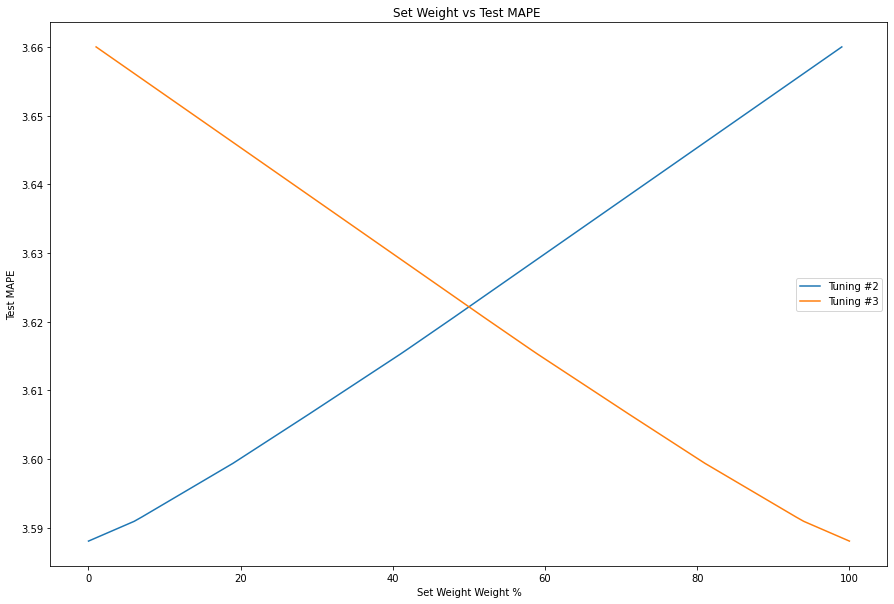

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(best_weight_x_arr*100, best_mape_arr, label = 'Tuning #2')
plt.plot(best_weight_y_arr*100, best_mape_arr, label = 'Tuning #3')
plt.xlabel('Set Weight Weight %')
plt.ylabel('Test MAPE')
plt.title('Set Weight vs Test MAPE ')
plt.legend()

### Tuning 5 (Lowering Iterations)

In [ ]:
cv = RepeatedKFold(n_splits = 3, random_state = 42, n_repeats=2)
model = CatBoostRegressor(logging_level='Silent', loss_function='MAPE')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

eval_pool = Pool(X_test, y_test)

fit_params = {'eval_set' : eval_pool,
              'early_stopping_rounds' : 10
             }


search = GridSearchCV(model, grid, scoring='neg_mean_absolute_percentage_error', cv=cv, verbose=3)

In [ ]:
tuning_five = search.fit(X_train, y_train, **fit_params)

In [ ]:
tuning_five.best_params_

{'depth': 4, 'iterations': 150, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [ ]:
tuning_five = CatBoostRegressor(depth=4, iterations=150, l2_leaf_reg=3, learning_rate=0.1)
tuning_five.fit(X_train, y_train)

In [ ]:
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, tuning_five.predict(X_test))*100} %')

Test MAPE: 3.6390884913656665 %


### Tuning 6 (3 and 5)

In [ ]:
preds_x = tuning_three.predict(X_test)
preds_y = tuning_five.predict(X_test)

best_weight_x_arr = np.arange(0.0, 1, 0.01)
best_weight_y_arr = np.arange(1, 0.0, -0.01)
best_mape_arr = []

best_weight_x = 0
best_mape_six = 100

for j in np.arange(0.0, 1, 0.01):
  weight_x = j
  weight_y = 1-weight_x

  final_preds = []

  for i in range(len(X_test)):
    pred = (weight_x*preds_x[i]) + (weight_y*preds_y[i])
    final_preds.append(pred)

  mape = mean_absolute_percentage_error(y_test, final_preds)*100
  best_mape_arr.append(mape)
  if (mape < best_mape_six):
    best_mape_six = mape
    best_weight_x = weight_x


print(f'Best Weight One: {best_weight_x}, Best Weight Two: {1-best_weight_x}')
print(f'Best MAPE: {best_mape_six}')
#print(f'Combined MAPE: {mean_absolute_percentage_error(y_test, final_preds)*100} %')


print(f'Tuning 3 MAPE: {mean_absolute_percentage_error(y_test, tuning_three.predict(X_test))*100} %')
print(f'Tuning 5 MAPE: {mean_absolute_percentage_error(y_test, tuning_five.predict(X_test))*100} %')
#print(f'Combined MAPE: {mean_absolute_percentage_error(y_test, final_preds)*100} %')

Best Weight One: 0.79, Best Weight Two: 0.20999999999999996
Best MAPE: 3.5859942359930006
Tuning 3 MAPE: 3.5880382076856203 %
Tuning 5 MAPE: 3.6390884913656665 %


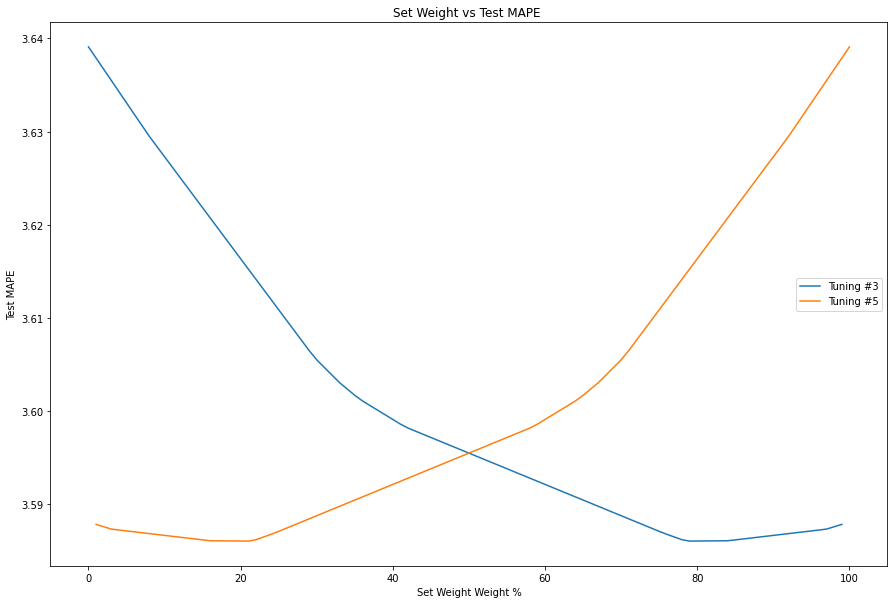

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(best_weight_x_arr*100, best_mape_arr, label = 'Tuning #3')
plt.plot(best_weight_y_arr*100, best_mape_arr, label = 'Tuning #5')
plt.xlabel('Set Weight Weight %')
plt.ylabel('Test MAPE')
plt.title('Set Weight vs Test MAPE ')
plt.legend()

### Results

In [ ]:
models_list = {'Tuning #': ['Untuned', 'Tuning #1', 'Tuning #2', 'Tuning #3', 'Tuning #4', 'Tuning #5', 'Tuning #6']}

results = pd.DataFrame(data = models_list)

linreg = np.zeros(7)
results['Best MAPE'] = linreg.copy()

results.iat[0, 1] = mean_absolute_percentage_error(y_test, untuned.predict(X_test))*100
results.iat[1, 1] = mean_absolute_percentage_error(y_test, tuning_one.predict(X_test))*100
results.iat[2, 1] = mean_absolute_percentage_error(y_test, tuning_two.predict(X_test))*100
results.iat[3, 1] = mean_absolute_percentage_error(y_test, tuning_three.predict(X_test))*100
results.iat[4, 1] = best_mape_four
results.iat[5, 1] = mean_absolute_percentage_error(y_test, tuning_five.predict(X_test))*100
results.iat[6, 1] = best_mape_six


display(results)

,Tuning #,Best MAPE
0,Untuned,3.718238
1,Tuning #1,3.670794
2,Tuning #2,3.660775
3,Tuning #3,3.588038
4,Tuning #4,3.588038
5,Tuning #5,3.639088
6,Tuning #6,3.585994
